In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import shutil
import logging

import random
from random import shuffle

import imgaug as ia
import imgaug.augmenters as iaa

logger = tf.get_logger()
logger.setLevel(logging.ERROR)


print("Num GPUS avadible:",len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUS avadible: 1


In [2]:

val_dir = os.path.join('val1_2cat' )
test1_dir = os.path.join('test1_2cat')

img_height=299
img_width=299
batch_size=16

In [3]:

val_0 = os.path.join(val_dir, '0') 
val_1 = os.path.join(val_dir, '1')

test_0 = os.path.join(test1_dir, '0') 
test_1 = os.path.join(test1_dir, '1')


#numeros
num_0_vl = len(os.listdir(val_0))
num_1_vl = len(os.listdir(val_1))

num_0_t = len(os.listdir(test_0))
num_1_t = len(os.listdir(test_1))


total_val = num_0_vl + num_1_vl
total_test = num_0_t + num_1_t

In [4]:
def rescale_0_to_1(image):
    """
    Rescale image to [0, 1].
    :param image:
        Required. Image tensor.
    :return:
        Scaled image.
    """
    return tf.image.convert_image_dtype(image, tf.float64)

def rescale_min_1_to_1(image):
    """
    Rescale image to [-1, 1].
    :param image:
        Required. Image tensor.
    :return:
        Scaled image.
    """
    # Image must be casted to float32 first.
    image = tf.cast(image, tf.float64)
    # Rescale image from [0, 255] to [0, 2].
    image = tf.multiply(image, 1. / 127.5)
    # Rescale to [-1, 1].
    return tf.subtract(image, 1.0)

In [5]:
image_gen_val = ImageDataGenerator(
    preprocessing_function=rescale_min_1_to_1
)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                   directory=val_dir,
                                                   target_size=(img_height,img_width),
                                                   class_mode='binary'
                                                  )

Found 16011 images belonging to 2 classes.


In [6]:
image_gen_test = ImageDataGenerator(
    preprocessing_function=rescale_min_1_to_1
)

test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
                                                   directory=test1_dir,
                                                   target_size=(img_height,img_width),
                                                   class_mode='binary'
                                                  )

Found 10296 images belonging to 2 classes.


In [7]:
import math  
   
####val####

number_of_examples1 = len(val_data_gen.filenames)
number_of_generator_calls1 = math.ceil(number_of_examples1 / (1.0 * batch_size)) 
# 1.0 above is to skip integer division

val_labels = []

for i in range(0,int(number_of_generator_calls1)):
    val_labels.extend(np.array(val_data_gen[i][1]))
    
    
    
    
####test####
    
number_of_examples2 = len(test_data_gen.filenames)
number_of_generator_calls2 = math.ceil(number_of_examples2 / (1.0 * batch_size)) 
# 1.0 above is to skip integer division

test_labels = []

for i in range(0,int(number_of_generator_calls2)):
    test_labels.extend(np.array(test_data_gen[i][1]))    

In [8]:
model = tf.keras.models.load_model('prueban15.h5')

y_pred1 =  model.predict_generator(val_data_gen, steps= int(np.ceil(total_val / float(batch_size))))

y_pred2 =  model.predict_generator(test_data_gen, steps= int(np.ceil(total_test / float(batch_size))))



In [9]:
from sklearn.metrics import roc_curve,roc_auc_score

fpr1 , tpr1 , thresholds1 = roc_curve ( val_labels , y_pred1)

fpr2 , tpr2 , thresholds2 = roc_curve ( test_labels , y_pred2)



In [10]:
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  


In [11]:
def tpr_to_umbrales(tpr,fpr,thresholds,lista):
    umbrales=[]
    fprumb=[]
    
    for i in lista:
        umbrales.append(thresholds[(np.where(tpr>=i))[0][0]])
        fprumb.append(fpr[(np.where(tpr>=i))[0][0]])
    
    return (umbrales, fprumb)

In [12]:
def umbral_mejor(tpr,fpr,thresholds):
    distancias=(1-tpr)+fpr
    
    umbral=thresholds[(np.where(distancias==min(distancias)))[0][0]]
    tpr1=tpr[(np.where(distancias==min(distancias)))[0][0]]
    fpr1=fpr[(np.where(distancias==min(distancias)))[0][0]]
    
    return (umbral,tpr1,fpr1)

Evaluación Validación


In [13]:
roc_auc_score(val_labels, y_pred1)

0.8063792971309226

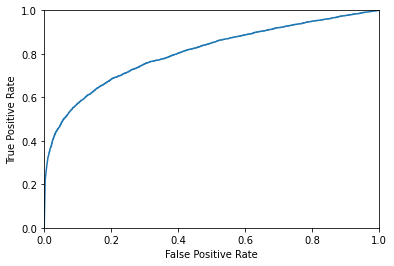

In [14]:
plot_roc_curve (fpr1,tpr1)

In [15]:
lista=[0.98,0.95,0.90,0.80]
  

umbrales , fprumb =tpr_to_umbrales(tpr1,fpr1,thresholds1,lista)

for idx,i in enumerate(lista):
    print("tpr:"+str(i)+"->fpr: "+str(fprumb[idx])+" con umbral: "+str(umbrales[idx]))

tpr:0.98->fpr: 0.9160993873383254 con umbral: 1.8172652e-36
tpr:0.95->fpr: 0.7992682096664397 con umbral: 6.0353884e-33
tpr:0.9->fpr: 0.6348706603131382 con umbral: 1.1861e-28
tpr:0.8->fpr: 0.39601769911504425 con umbral: 1.13140924e-20


In [16]:
umbral_1,tpr_1,fpr_1=umbral_mejor(tpr1,fpr1,thresholds1)

print("tpr:"+str(tpr_1)+"->fpr: "+str(fpr_1)+" con umbral: "+str(umbral_1))

tpr:0.6428739140643344->fpr: 0.15852620830496936 con umbral: 2.1294605e-08


Evaluación test 


In [17]:
roc_auc_score(test_labels, y_pred2)

0.8066084842680361

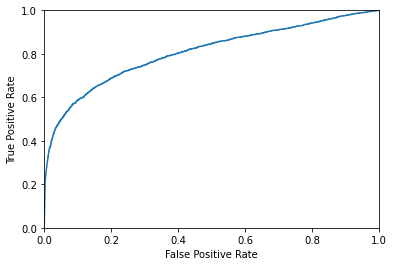

In [18]:
plot_roc_curve (fpr2,tpr2)

In [19]:

umbrales , fprumb =tpr_to_umbrales(tpr2,fpr2,thresholds2,lista)

for idx,i in enumerate(lista):
    print("tpr:"+str(i)+"->fpr: "+str(fprumb[idx])+" con umbral: "+str(umbrales[idx]))

tpr:0.98->fpr: 0.9109669046073978 con umbral: 3.924286e-36
tpr:0.95->fpr: 0.8243997404282933 con umbral: 2.4146904e-33
tpr:0.9->fpr: 0.6622972096041532 con umbral: 3.8389986e-29
tpr:0.8->fpr: 0.3931213497728748 con umbral: 1.907234e-20


In [20]:
umbral_2,tpr_2,fpr_2=umbral_mejor(tpr2,fpr2,thresholds2)

print("tpr:"+str(tpr_2)+"->fpr: "+str(fpr_2)+" con umbral: "+str(umbral_2))

tpr:0.6402933230412968->fpr: 0.14497079818299805 con umbral: 2.3793562e-07
